## Gradient tapes

In [1]:
import tensorflow as tf
print(tf.__version__)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
2.6.0-dev20210412


In [3]:
x = tf.ones((2, 2))

print('x:', x)

with tf.GradientTape() as t:
    
    t.watch(x)
    
    y = tf.reduce_sum(x)
    print('\ny:', y)
    
    z = tf.multiply(y, y)
    print('\nz:', z)

# Derivative of z with respect to the original input tensor x
dz_dx = t.gradient(z, x)

# Since the input tensor shape is (2, 2), we expect the gradient 
# to have the same shape (4 partial derivative components)
print('\ndz_dx:', dz_dx)

for i in  [0, 1]:
    for j in [0, 1]:
        assert dz_dx[i, j].numpy() == 8.0

x: tf.Tensor(
[[1. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)

y: tf.Tensor(4.0, shape=(), dtype=float32)

z: tf.Tensor(16.0, shape=(), dtype=float32)

dz_dx: tf.Tensor(
[[8. 8.]
 [8. 8.]], shape=(2, 2), dtype=float32)


## dz_dx = dz/dy * dy/dx (Chain Rule)
You can also request gradients of the output with respect to intermediate values during a "recorded" `tf.GradientTape` context.

In [5]:
x = tf.ones((2, 2))

print('x:', x)

with tf.GradientTape() as t:
    
    t.watch(x)
    
    y = tf.reduce_sum(x)
    
    print('\ny:', y)
    
    z = tf.multiply(y, y)
    
    print('\nz:', z)
    
# Use the tape to compute the derivative of z with respect to the
# intermediate value y.
dz_dy = t.gradient(z, y)
# dy_dx = t.gradient(y, x)  # can't do this without persisitent=True

print('\ndz_dy:', dz_dy)
# print('\ndy_dx:', dy_dx)

assert dz_dy.numpy() == 8.0

x: tf.Tensor(
[[1. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)

y: tf.Tensor(4.0, shape=(), dtype=float32)

z: tf.Tensor(16.0, shape=(), dtype=float32)

dz_dy: tf.Tensor(8.0, shape=(), dtype=float32)


By default, the resources held by a `GradientTape` are released as soon as `GradientTape.gradient()` method is called. To compute multiple gradients over the same computation, create a `persistent` gradient tape. This allows multiple calls to the `gradient()` method as resources are released when the tape object is garbage collected.

In [6]:
x = tf.constant(3.)

print('x:', x)

with tf.GradientTape(persistent=True) as t:
    
    t.watch(x)
    
    y = x * x
    
    print('\ny:', y)
    
    z = tf.multiply(y, y)
    
    print('\nz:', z)
    
dz_dx = t.gradient(z, x)  # 108.0 (4*x^3 at x=3)
print('\ndz_dx:', dz_dx)

dz_dy = t.gradient(z, y)  # 18.0
print('\ndz_dy:', dz_dy)

dy_dx = t.gradient(y, x)
print('\ndy_dx', dy_dx)  # 6.0

x: tf.Tensor(3.0, shape=(), dtype=float32)

y: tf.Tensor(9.0, shape=(), dtype=float32)

z: tf.Tensor(81.0, shape=(), dtype=float32)

dz_dx: tf.Tensor(108.0, shape=(), dtype=float32)

dz_dy: tf.Tensor(18.0, shape=(), dtype=float32)

dy_dx tf.Tensor(6.0, shape=(), dtype=float32)


## Recording control flow

In [7]:
def f(x, y):
    
    output = 1.0
    
    for i in range(y):
        if i > 1 and i < 5:
            output = tf.multiply(output, x)
    
    return output

def grad(x, y):
    
    with tf.GradientTape() as t:
        t.watch(x)
        out = f(x, y)
    return t.gradient(out, x)

x = tf.convert_to_tensor(2.0)

assert grad(x, 6).numpy() == 12.0
assert grad(x, 5).numpy() == 12.0
assert grad(x, 4).numpy() == 4.0

## Higher-order gradients
Operations inside the `GradientTape` context manager are recorded for automatic differentiation. If gradients are computed in that context, then the gradient computation is recorded as well. As a result, the exact same API works for higher-order gradients as well.

In [8]:
x = tf.Variable(1.)

with tf.GradientTape() as t:
    with tf.GradientTape() as t2:
        y = x * x * x
    dy_dx = t2.gradient(y, x)
d2y_dx2 = t.gradient(dy_dx, x)

assert dy_dx.numpy() == 3.0
assert d2y_dx2.numpy() == 6.0

## Jacobians

The `Jacobian matrix` represents the gradients of a vector valued function. Each row contains the gradient of one of the vector's elements.

### Scalar source

In [10]:
x = tf.linspace(-10., 10., 200+1)
delta = tf.Variable(0.0)

with tf.GradientTape() as tape:
    y = tf.nn.sigmoid(x+delta)

dy_dx = tape.jacobian(y, delta)

print(y.shape)
print(dy_dx.shape)

(201,)
(201,)


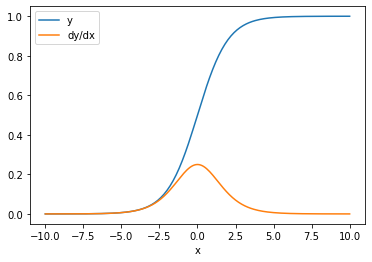

In [12]:
import matplotlib.pyplot as plt

plt.plot(x.numpy(), y, label='y')
plt.plot(x.numpy(), dy_dx, label='dy/dx')
plt.legend()
_ = plt.xlabel('x')

### Tensor source

In [13]:
x = tf.random.normal([7, 5])
layer = tf.keras.layers.Dense(10, activation=tf.nn.relu)

with tf.GradientTape(persistent=True) as tape:
    y = layer(x)

y.shape

TensorShape([7, 10])

In [14]:
layer.kernel.shape

TensorShape([5, 10])

In [15]:
j = tape.jacobian(y, layer.kernel)
j.shape

TensorShape([7, 10, 5, 10])

In [16]:
g = tape.gradient(y, layer.kernel)
print('g.shape:', g.shape)

j_sum = tf.reduce_sum(j, axis=[0, 1])
delta = tf.reduce_max(abs(g - j_sum)).numpy()
assert delta < 1e-3
print('delta:', delta)

g.shape: (5, 10)
delta: 0.0
